interpolacja: nearest-neighbourhood, PiecewiseAffineTransform.estimate


Najlepsze dopasowanie:
Plik: 1__M_Left_index_finger.BMP
Czas dopasowania: 0.0030 s
Liczba dopasowanych punktów: 9
Średnia różnica pikseli: 2.345064724919094


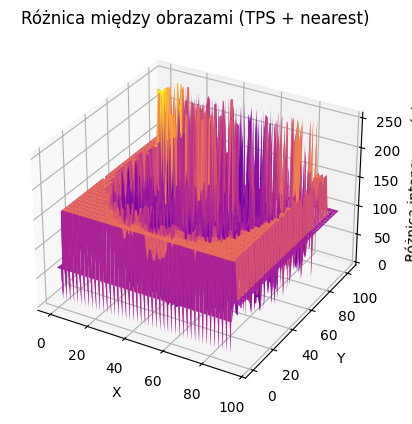

Średnia różnica pikseli po TPS: 103.78357605177993


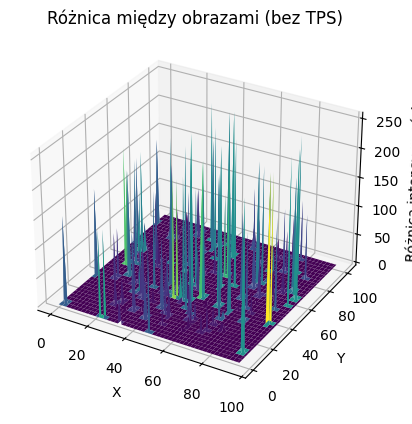

Koniec skryptu.


In [6]:
import cv2
import os
import numpy as np
import time
import matplotlib.pyplot as plt
from skimage.transform import PiecewiseAffineTransform, warp

# Ścieżki
test_path = r"C:\Users\jacek\OneDrive\Pulpit\inf_med_4\Altered-custom\1__M_Left_index_finger_szum.BMP"
dataDir = r"C:\Users\jacek\OneDrive\Pulpit\inf_med_4\Real_subset"

# Wczytanie obrazu testowego
test_original = cv2.imread(test_path, cv2.IMREAD_GRAYSCALE)
if test_original is None:
    print("❌ Nie udało się wczytać obraz testowy.")
    exit()

# Funkcje pomocnicze
def preprocess(image):
    return image

def features_extraction(image):
    return sift.detectAndCompute(image, None)

# Inicjalizacja SIFT
sift = cv2.SIFT_create()
test_preprocessed = preprocess(test_original)
keypoints_1, descriptors_1 = features_extraction(test_preprocessed)

# Struktura z najlepszym dopasowaniem
best = {
    "file": "",
    "image": None,
    "keypoints_2": [],
    "matches": [],
    "match_time": 0,
    "mean_diff": 0
}

# Szukaj najlepszego dopasowania
for file in os.listdir(dataDir):
    path = os.path.join(dataDir, file)
    db_image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if db_image is None:
        continue

    start = time.time()
    keypoints_2, descriptors_2 = features_extraction(preprocess(db_image))

    flann = cv2.FlannBasedMatcher(dict(algorithm=1, trees=10), dict())
    matches = flann.knnMatch(descriptors_1, descriptors_2, k=2)

    match_points = []
    for m in matches:
        if len(m) == 2:
            p, q = m
            if p.distance < 0.1 * q.distance:
                match_points.append(p)

    end = time.time()
    match_time = end - start

    keypoints_count = min(len(keypoints_1), len(keypoints_2))
    if keypoints_count == 0:
        continue

    match_ratio = len(match_points) / keypoints_count

    if match_ratio > len(best["matches"]) / keypoints_count:
        best.update({
            "file": file,
            "image": db_image,
            "keypoints_2": keypoints_2,
            "matches": match_points,
            "match_time": match_time,
            "mean_diff": np.mean(cv2.absdiff(test_preprocessed, preprocess(db_image)))
        })

# Wypisz dane do raportu
print("\nNajlepsze dopasowanie:")
print("Plik:", best["file"])
print("Czas dopasowania: {:.4f} s".format(best["match_time"]))
print("Liczba dopasowanych punktów:", len(best["matches"]))
print("Średnia różnica pikseli:", best["mean_diff"])

# Obraz różnicowy (bez transformacji)
diff_img = cv2.absdiff(test_preprocessed, preprocess(best["image"]))
cv2.imshow("Obraz różnicowy - bez transformacji", diff_img)

# Checkerboard
checker = test_preprocessed.copy()
checker[::20, :] = preprocess(best["image"])[::20, :]
cv2.imshow("Checkerboard", checker)

# Dopasowanie SIFT + FLANN
result = cv2.drawMatches(test_original, keypoints_1, best["image"],
                         best["keypoints_2"], best["matches"], None)
result = cv2.resize(result, None, fx=2.0, fy=2.0)
cv2.imshow("Dopasowanie", result)

# Transformacja TPS z interpolacją nearest
src_pts = np.float32([keypoints_1[m.queryIdx].pt for m in best["matches"]])
dst_pts = np.float32([best["keypoints_2"][m.trainIdx].pt for m in best["matches"]])

tps_transform = PiecewiseAffineTransform()

if len(src_pts) > 2:
    tps_transform.estimate(src_pts, dst_pts)
    warped = warp(test_preprocessed, tps_transform, order=0, mode='edge')
    warped_8u = (warped * 255).astype(np.uint8)

    diff_img_tps = cv2.absdiff(warped_8u, preprocess(best["image"]))
    cv2.imshow("Obraz różnicowy - TPS (nearest)", diff_img_tps)

    # Wykres 3D po TPS
    X_tps = np.arange(diff_img_tps.shape[1])
    Y_tps = np.arange(diff_img_tps.shape[0])
    X_tps, Y_tps = np.meshgrid(X_tps, Y_tps)

    fig_tps = plt.figure()
    ax_tps = fig_tps.add_subplot(111, projection='3d')
    ax_tps.plot_surface(X_tps, Y_tps, diff_img_tps, cmap='plasma')
    ax_tps.set_title('Różnica między obrazami (TPS + nearest)')
    ax_tps.set_xlabel('X')
    ax_tps.set_ylabel('Y')
    ax_tps.set_zlabel('Różnica intensywności')

    plt.show()

    mean_diff_tps = np.mean(diff_img_tps)
    print("Średnia różnica pikseli po TPS:", mean_diff_tps)
else:
    print("Za mało punktów do estymacji TPS/Piecewise-Affine.")

# Zatrzymanie i zamknięcie okien OpenCV
cv2.waitKey(0)
cv2.destroyAllWindows()

# Wykres 3D różnicy (bez TPS)
diff = cv2.absdiff(test_preprocessed, preprocess(best["image"]))
X = np.arange(diff.shape[1])
Y = np.arange(diff.shape[0])
X, Y = np.meshgrid(X, Y)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, diff, cmap='viridis')
ax.set_title('Różnica między obrazami (bez TPS)')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Różnica intensywności')
plt.show()

print("Koniec skryptu.")


zamiana sift_flann na akaze+bruteforcematcher z TPS


Najlepsze dopasowanie:
Plik: 1__M_Left_index_finger.BMP
Czas dopasowania: 0.0000 s
Liczba dopasowanych punktów: 12
Średnia różnica pikseli: 2.345064724919094


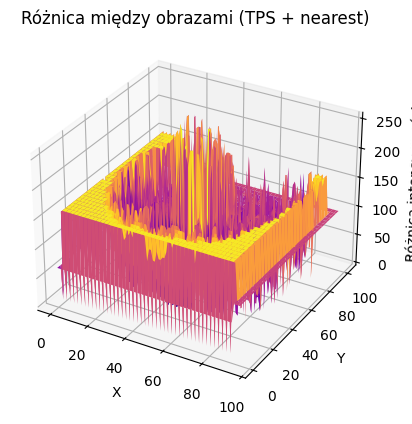

Średnia różnica pikseli po TPS: 104.25505663430421


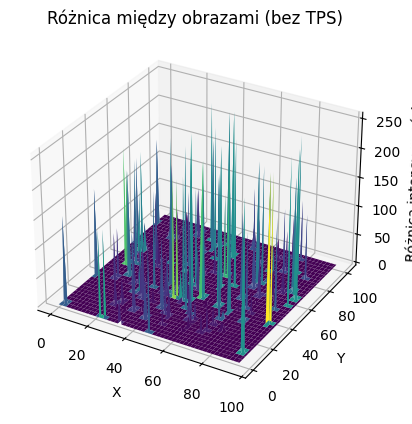

In [7]:
import cv2
import os
import numpy as np
import time
import matplotlib.pyplot as plt
from skimage.transform import PiecewiseAffineTransform, warp

# Ścieżki
test_path = r"C:\Users\jacek\OneDrive\Pulpit\inf_med_4\Altered-custom\1__M_Left_index_finger_szum.BMP"
dataDir = r"C:\Users\jacek\OneDrive\Pulpit\inf_med_4\Real_subset"

# Wczytanie obrazu testowego
test_original = cv2.imread(test_path, cv2.IMREAD_GRAYSCALE)
if test_original is None:
    print("❌ Nie udało się wczytać obraz testowy.")
    exit()

# AKAZE zamiast SIFT
akaze = cv2.AKAZE_create()

def preprocess(image):
    return image

def features_extraction(image):
    return akaze.detectAndCompute(image, None)

test_preprocessed = preprocess(test_original)
keypoints_1, descriptors_1 = features_extraction(test_preprocessed)

# Struktura z najlepszym dopasowaniem
best = {
    "file": "",
    "image": None,
    "keypoints_2": [],
    "matches": [],
    "match_time": 0,
    "mean_diff": 0
}

# BruteForceMatcher
bf = cv2.BFMatcher(cv2.NORM_HAMMING)

for file in os.listdir(dataDir):
    path = os.path.join(dataDir, file)
    db_image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if db_image is None:
        continue

    # Automatyczne dopasowanie rozmiaru
    if db_image.shape != test_preprocessed.shape:
        db_image = cv2.resize(db_image, (test_preprocessed.shape[1], test_preprocessed.shape[0]))

    keypoints_2, descriptors_2 = features_extraction(preprocess(db_image))
    if descriptors_1 is None or descriptors_2 is None:
        continue

    start = time.time()
    matches = bf.knnMatch(descriptors_1, descriptors_2, k=2)

    match_points = []
    for m in matches:
        if len(m) == 2:
            p, q = m
            if p.distance < 0.8 * q.distance:  # <- bardziej tolerancyjny próg
                match_points.append(p)
    end = time.time()
    match_time = end - start

    keypoints_count = min(len(keypoints_1), len(keypoints_2))
    if keypoints_count == 0:
        continue

    match_ratio = len(match_points) / keypoints_count

    if match_ratio > len(best["matches"]) / keypoints_count:
        best.update({
            "file": file,
            "image": db_image,
            "keypoints_2": keypoints_2,
            "matches": match_points,
            "match_time": match_time,
            "mean_diff": np.mean(cv2.absdiff(test_preprocessed, preprocess(db_image)))
        })

# Wypisz dane do raportu
print("\nNajlepsze dopasowanie:")
print("Plik:", best["file"])
print("Czas dopasowania: {:.4f} s".format(best["match_time"]))
print("Liczba dopasowanych punktów:", len(best["matches"]))
print("Średnia różnica pikseli:", best["mean_diff"])

if best["image"] is not None:
    # Obraz różnicowy
    diff_img = cv2.absdiff(test_preprocessed, preprocess(best["image"]))
    cv2.imshow("Obraz różnicowy", diff_img)

    # Checkerboard
    checker = test_preprocessed.copy()
    checker[::20, :] = preprocess(best["image"])[::20, :]
    cv2.imshow("Checkerboard", checker)

    # Dopasowanie
    result = cv2.drawMatches(test_original, keypoints_1, best["image"],
                             best["keypoints_2"], best["matches"], None)
    result = cv2.resize(result, None, fx=2.0, fy=2.0)
    cv2.imshow("Dopasowanie", result)

    # TRANSFORMACJA TPS
    src_pts = np.float32([keypoints_1[m.queryIdx].pt for m in best["matches"]])
    dst_pts = np.float32([best["keypoints_2"][m.trainIdx].pt for m in best["matches"]])
    tps_transform = PiecewiseAffineTransform()

    if len(src_pts) > 2:
        tps_transform.estimate(src_pts, dst_pts)
        warped = warp(test_preprocessed, tps_transform, order=0, mode='edge')
        warped_8u = (warped * 255).astype(np.uint8)

        diff_img_tps = cv2.absdiff(warped_8u, preprocess(best["image"]))
        cv2.imshow("Obraz różnicowy - TPS (nearest)", diff_img_tps)

        # Wykres 3D po TPS
        X_tps = np.arange(diff_img_tps.shape[1])
        Y_tps = np.arange(diff_img_tps.shape[0])
        X_tps, Y_tps = np.meshgrid(X_tps, Y_tps)

        fig_tps = plt.figure()
        ax_tps = fig_tps.add_subplot(111, projection='3d')
        ax_tps.plot_surface(X_tps, Y_tps, diff_img_tps, cmap='plasma')
        ax_tps.set_title('Różnica między obrazami (TPS + nearest)')
        ax_tps.set_xlabel('X')
        ax_tps.set_ylabel('Y')
        ax_tps.set_zlabel('Różnica intensywności')
        plt.show()

        print("Średnia różnica pikseli po TPS:", np.mean(diff_img_tps))
    else:
        print("Za mało punktów do transformacji TPS.")

    # Wykres 3D różnicy (bez TPS)
    diff = cv2.absdiff(test_preprocessed, preprocess(best["image"]))
    X = np.arange(diff.shape[1])
    Y = np.arange(diff.shape[0])
    X, Y = np.meshgrid(X, Y)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, diff, cmap='viridis')
    ax.set_title('Różnica między obrazami (bez TPS)')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Różnica intensywności')
    plt.show()

    cv2.waitKey(0)
    cv2.destroyAllWindows()
else:
    print("❌ Brak najlepszego dopasowania lub problem z obrazami.")


orb+bruteforce


Najlepsze dopasowanie:
Plik: 1__M_Left_index_finger.BMP
Czas dopasowania: 0.0010 s
Liczba dopasowanych punktów: 90
Średnia różnica pikseli: 2.345064724919094


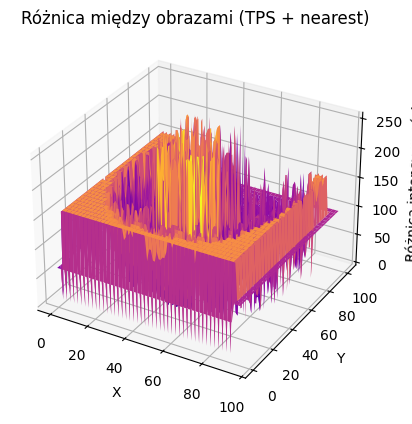

Średnia różnica pikseli po TPS: 106.36347087378641


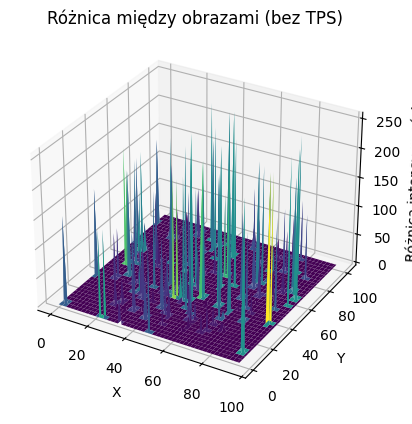

In [8]:
import cv2
import os
import numpy as np
import time
import matplotlib.pyplot as plt
from skimage.transform import PiecewiseAffineTransform, warp

# Ścieżki
test_path = r"C:\Users\jacek\OneDrive\Pulpit\inf_med_4\Altered-custom\1__M_Left_index_finger_szum.BMP"
dataDir = r"C:\Users\jacek\OneDrive\Pulpit\inf_med_4\Real_subset"

# Wczytanie obrazu testowego
test_original = cv2.imread(test_path, cv2.IMREAD_GRAYSCALE)
if test_original is None:
    print("❌ Nie udało się wczytać obraz testowy.")
    exit()

# ORB zamiast AKAZE/SIFT
orb = cv2.ORB_create(nfeatures=1000)

def preprocess(image):
    return image

def features_extraction(image):
    return orb.detectAndCompute(image, None)

test_preprocessed = preprocess(test_original)
keypoints_1, descriptors_1 = features_extraction(test_preprocessed)

# Struktura z najlepszym dopasowaniem
best = {
    "file": "",
    "image": None,
    "keypoints_2": [],
    "matches": [],
    "match_time": 0,
    "mean_diff": 0
}

# BruteForceMatcher
bf = cv2.BFMatcher(cv2.NORM_HAMMING)

for file in os.listdir(dataDir):
    path = os.path.join(dataDir, file)
    db_image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if db_image is None:
        continue

    # Automatyczne dopasowanie rozmiaru
    if db_image.shape != test_preprocessed.shape:
        db_image = cv2.resize(db_image, (test_preprocessed.shape[1], test_preprocessed.shape[0]))

    keypoints_2, descriptors_2 = features_extraction(preprocess(db_image))
    if descriptors_1 is None or descriptors_2 is None:
        continue

    start = time.time()
    matches = bf.knnMatch(descriptors_1, descriptors_2, k=2)

    match_points = []
    for m in matches:
        if len(m) == 2:
            p, q = m
            if p.distance < 0.8 * q.distance:  # ratio test (łagodny)
                match_points.append(p)
    end = time.time()
    match_time = end - start

    keypoints_count = min(len(keypoints_1), len(keypoints_2))
    if keypoints_count == 0:
        continue

    match_ratio = len(match_points) / keypoints_count

    if match_ratio > len(best["matches"]) / keypoints_count:
        best.update({
            "file": file,
            "image": db_image,
            "keypoints_2": keypoints_2,
            "matches": match_points,
            "match_time": match_time,
            "mean_diff": np.mean(cv2.absdiff(test_preprocessed, preprocess(db_image)))
        })

# Wypisz dane do raportu
print("\nNajlepsze dopasowanie:")
print("Plik:", best["file"])
print("Czas dopasowania: {:.4f} s".format(best["match_time"]))
print("Liczba dopasowanych punktów:", len(best["matches"]))
print("Średnia różnica pikseli:", best["mean_diff"])

if best["image"] is not None:
    # Obraz różnicowy
    diff_img = cv2.absdiff(test_preprocessed, preprocess(best["image"]))
    cv2.imshow("Obraz różnicowy", diff_img)

    # Checkerboard
    checker = test_preprocessed.copy()
    checker[::20, :] = preprocess(best["image"])[::20, :]
    cv2.imshow("Checkerboard", checker)

    # Dopasowanie
    result = cv2.drawMatches(test_original, keypoints_1, best["image"],
                             best["keypoints_2"], best["matches"], None)
    result = cv2.resize(result, None, fx=2.0, fy=2.0)
    cv2.imshow("Dopasowanie", result)

    # TRANSFORMACJA TPS
    src_pts = np.float32([keypoints_1[m.queryIdx].pt for m in best["matches"]])
    dst_pts = np.float32([best["keypoints_2"][m.trainIdx].pt for m in best["matches"]])
    tps_transform = PiecewiseAffineTransform()

    if len(src_pts) > 2:
        tps_transform.estimate(src_pts, dst_pts)
        warped = warp(test_preprocessed, tps_transform, order=0, mode='edge')
        warped_8u = (warped * 255).astype(np.uint8)

        diff_img_tps = cv2.absdiff(warped_8u, preprocess(best["image"]))
        cv2.imshow("Obraz różnicowy - TPS (nearest)", diff_img_tps)

        # Wykres 3D po TPS
        X_tps = np.arange(diff_img_tps.shape[1])
        Y_tps = np.arange(diff_img_tps.shape[0])
        X_tps, Y_tps = np.meshgrid(X_tps, Y_tps)

        fig_tps = plt.figure()
        ax_tps = fig_tps.add_subplot(111, projection='3d')
        ax_tps.plot_surface(X_tps, Y_tps, diff_img_tps, cmap='plasma')
        ax_tps.set_title('Różnica między obrazami (TPS + nearest)')
        ax_tps.set_xlabel('X')
        ax_tps.set_ylabel('Y')
        ax_tps.set_zlabel('Różnica intensywności')
        plt.show()

        print("Średnia różnica pikseli po TPS:", np.mean(diff_img_tps))
    else:
        print("Za mało punktów do transformacji TPS.")

    # Wykres 3D różnicy (bez TPS)
    diff = cv2.absdiff(test_preprocessed, preprocess(best["image"]))
    X = np.arange(diff.shape[1])
    Y = np.arange(diff.shape[0])
    X, Y = np.meshgrid(X, Y)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, diff, cmap='viridis')
    ax.set_title('Różnica między obrazami (bez TPS)')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Różnica intensywności')
    plt.show()

    cv2.waitKey(0)
    cv2.destroyAllWindows()
else:
    print("❌ Brak najlepszego dopasowania lub problem z obrazami.")



Najlepsze dopasowanie:
Plik: 1__M_Left_index_finger.BMP
Czas dopasowania: 0.0030 s
Liczba dopasowanych punktów: 9
Średnia różnica pikseli: 2.345064724919094


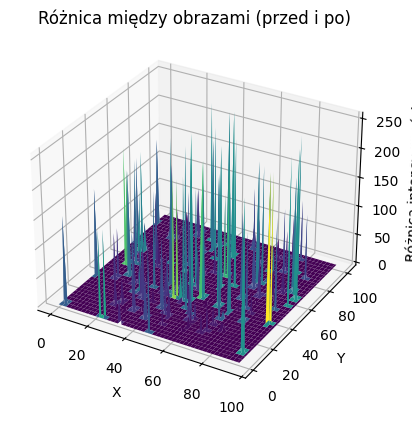

In [2]:
import cv2
import os
import numpy as np
import time
import matplotlib.pyplot as plt

# Ścieżki
test_path = r"C:\Users\jacek\OneDrive\Pulpit\inf_med_4\Altered-custom\1__M_Left_index_finger_szum.BMP"
dataDir = r"C:\Users\jacek\OneDrive\Pulpit\inf_med_4\Real_subset"

# Wczytanie obrazu testowego
test_original = cv2.imread(test_path, cv2.IMREAD_GRAYSCALE)
if test_original is None:
    print("❌ Nie udało się wczytać obraz testowy.")
    exit()

# Funkcje pomocnicze
def preprocess(image):
    return image

def features_extraction(image):
    return sift.detectAndCompute(image, None)

# Inicjalizacja
sift = cv2.SIFT_create()
test_preprocessed = preprocess(test_original)
keypoints_1, descriptors_1 = features_extraction(test_preprocessed)

# Szukaj najlepszego dopasowania
best = {
    "file": "",
    "image": None,
    "keypoints_2": [],
    "matches": [],
    "match_time": 0,
    "mean_diff": 0
}

for file in os.listdir(dataDir):
    path = os.path.join(dataDir, file)
    db_image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if db_image is None:
        continue

    start = time.time()
    keypoints_2, descriptors_2 = features_extraction(preprocess(db_image))

    matches = cv2.FlannBasedMatcher(dict(algorithm=1, trees=10), dict()).knnMatch(descriptors_1, descriptors_2, k=2)

    match_points = []
    for p, q in matches:
        if p.distance < 0.1 * q.distance:
            match_points.append(p)

    end = time.time()
    match_time = end - start

    keypoints_count = min(len(keypoints_1), len(keypoints_2))
    if keypoints_count == 0:
        continue

    match_ratio = len(match_points) / keypoints_count

    # Jeśli to najlepszy dotąd wynik – zapisz
    if match_ratio > len(best["matches"]) / keypoints_count:
        best.update({
            "file": file,
            "image": db_image,
            "keypoints_2": keypoints_2,
            "matches": match_points,
            "match_time": match_time,
            "mean_diff": np.mean(cv2.absdiff(test_preprocessed, preprocess(db_image)))
        })

# 📝 WYPISZ DANE DO RAPORTU
print("\nNajlepsze dopasowanie:")
print("Plik:", best["file"])
print("Czas dopasowania: {:.4f} s".format(best["match_time"]))
print("Liczba dopasowanych punktów:", len(best["matches"]))
print("Średnia różnica pikseli:", best["mean_diff"])

# 🖼️ OBRAZ RÓŻNICOWY
diff_img = cv2.absdiff(test_preprocessed, preprocess(best["image"]))
cv2.imshow("Obraz różnicowy", diff_img)

# ♟️ SZACHOWNICA (checkerboard)
checker = test_preprocessed.copy()
checker[::20, :] = preprocess(best["image"])[::20, :]
cv2.imshow("Checkerboard", checker)

# 🔗 DOPASOWANIE
result = cv2.drawMatches(test_original, keypoints_1, best["image"],
                         best["keypoints_2"], best["matches"], None)
result = cv2.resize(result, None, fx=2.0, fy=2.0)
cv2.imshow("Dopasowanie", result)

cv2.waitKey(0)
cv2.destroyAllWindows()

# Różnica pikseli (po preprocessingu!)
diff = cv2.absdiff(test_preprocessed, preprocess(best["image"]))

# Tworzymy siatkę X, Y
X = np.arange(diff.shape[1])
Y = np.arange(diff.shape[0])
X, Y = np.meshgrid(X, Y)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, diff, cmap='viridis')
ax.set_title('Różnica między obrazami (przed i po)')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Różnica intensywności')
plt.show()
